## Customer Segmentation using RFM Analysis

This analysis focuses on customer segmentation using **RFM analysis (Recency, Frequency, Monetary)** combined with **KMeans clustering**. The primary goal is to identify patterns in customer purchasing behavior and group customers into meaningful segments to support targeted marketing strategies.

The dataset used contains order-level information, including:
- `id`: Unique order identifier  
- `created_at`: Timestamp of when the order was placed  
- `sales_amount`: Monetary value of the order  
- `customer_id`: Unique identifier for each customer

By transforming the data into an RFM framework and applying clustering techniques, we aim to:
- Understand different types of customer behaviors
- Segment customers based on their transactional history
- Recommend business strategies tailored to each segment

This approach enables data-driven decision-making and helps businesses enhance customer engagement, retention, and overall profitability.


In [1]:
!pip install pyarrow --quiet



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore') ## need to use this because my pyarrow is not global


In [3]:
#Load the dataset into your jupyter notebook
df = pd.read_parquet("orders.parquet", engine="pyarrow")
df.head()


,id,created_at,sales_amount,customer_id
0,29503467,2024-12-30 19:24:05,3.45,2937655
1,29511871,2024-12-30 22:09:52,3.45,1865364
2,29517274,2024-12-31 08:30:45,3.45,896267
3,29561364,2024-12-31 16:35:49,3.45,4077636
4,29562591,2024-12-31 16:50:58,3.45,124644


In [4]:
print("Shape:", df.shape)


Shape: (3927651, 4)


In [5]:
#Perform initial data quality checks
df.duplicated().sum()


np.int64(0)

In [6]:
print("\nMissing Values:\n", df.isnull().sum())



Missing Values:
 id              0
created_at      0
sales_amount    0
customer_id     0
dtype: int64


In [7]:
print("\nData Types:\n", df.dtypes)



Data Types:
 id                      object
created_at      datetime64[ns]
sales_amount           float64
customer_id             object
dtype: object


In [8]:
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
                           created_at  sales_amount
count                        3927651  3.927651e+06
mean   2024-07-19 23:52:36.632740608  1.549553e+01
min              2024-01-01 06:10:16  3.020000e+00
25%              2024-04-18 13:02:56  8.910000e+00
50%              2024-07-26 12:22:03  1.161000e+01
75%       2024-10-27 13:15:14.500000  1.904000e+01
max              2024-12-31 23:51:17  7.239000e+02
std                              NaN  1.183016e+01


In [9]:
df['customer_id'].nunique()


730485

Date range: 2024-01-01 06:10:16 to 2024-12-31 23:51:17


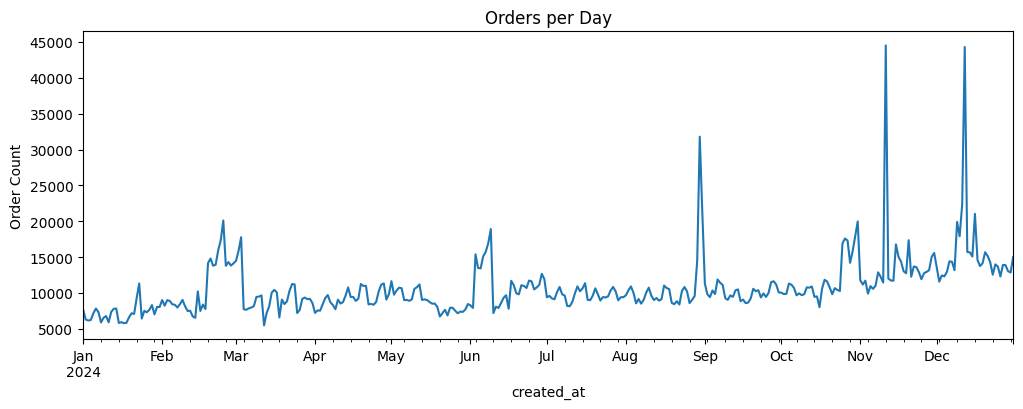

In [10]:

df['created_at'] = pd.to_datetime(df['created_at'])
print("Date range:", df['created_at'].min(), "to", df['created_at'].max())


df.set_index('created_at')['id'].resample('D').count().plot(figsize=(12,4), title="Orders per Day")
plt.ylabel("Order Count")
plt.show()



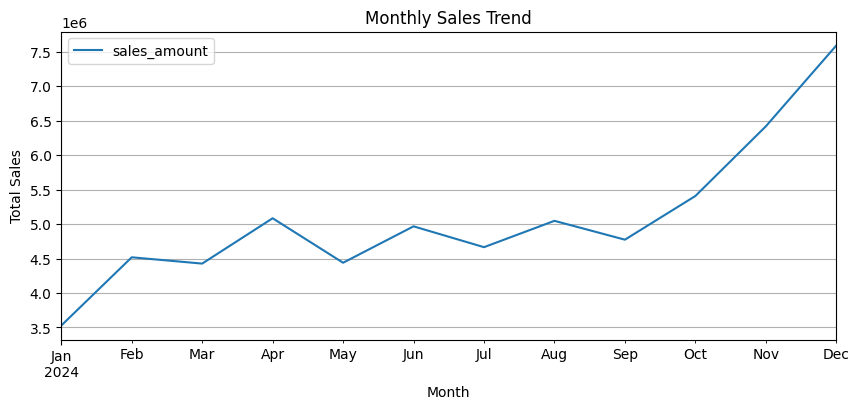

In [11]:
# Monthly Sales Trend
df_monthly = df.resample('M', on='created_at').agg({'sales_amount': 'sum'})
df_monthly.plot(figsize=(10, 4), title="Monthly Sales Trend")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.grid(True)
plt.show()


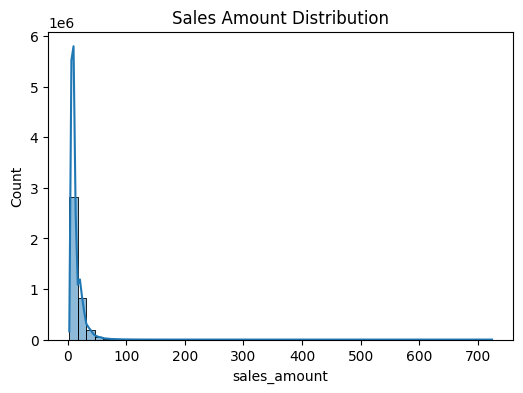

In [12]:

plt.figure(figsize=(6, 4))
sns.histplot(df['sales_amount'], bins=50, kde=True)
plt.title("Sales Amount Distribution")
plt.show()


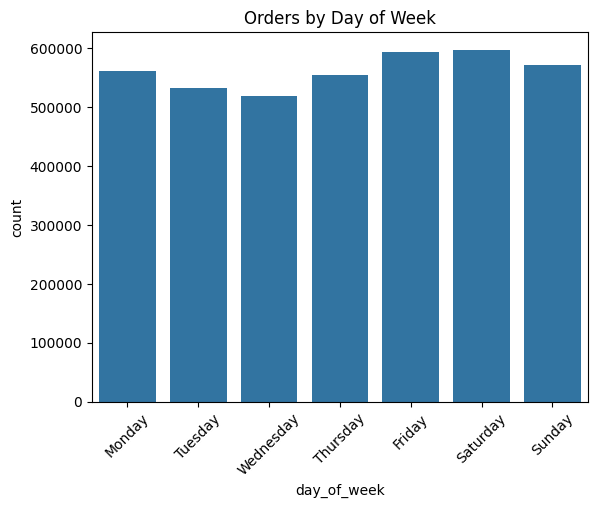

In [13]:


df['day_of_week'] = df['created_at'].dt.day_name()
sns.countplot(data=df, x='day_of_week', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Orders by Day of Week")
plt.xticks(rotation=45)
plt.show()


In [14]:
# RFM to get jsut the dat we want to use for the RFM not everything
# the way rfm works is for individual customers not as a groud data

reference_date = df['created_at'].max()

rfm = df.groupby('customer_id').agg({
    'created_at': lambda x: (reference_date - x.max()).days,
    'id': 'count',
    'sales_amount': 'sum'
}).reset_index()


rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
print(rfm.head())


  customer_id  Recency  Frequency  Monetary
0     1000015       17          4    158.11
1      100002       45         20    334.03
2     1000020       67          6     52.10
3     1000029        3         55    838.79
4     1000035       15          8    125.11


In [15]:
print("Sample customer_id from RFM:", rfm['customer_id'].iloc[0])



Sample customer_id from RFM: 1000015


In [16]:
print("Matching in original df:", df[df['customer_id'] == rfm['customer_id'].iloc[0]])

Matching in original df:                id          created_at  sales_amount customer_id day_of_week
1676028  19146299 2024-06-22 15:55:31         13.81     1000015    Saturday
1830498  14577840 2024-03-07 13:11:03        101.00     1000015    Thursday
2294870  18956342 2024-06-18 15:30:33         14.90     1000015     Tuesday
3269979  28380977 2024-12-14 16:06:48         28.40     1000015    Saturday


In [17]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


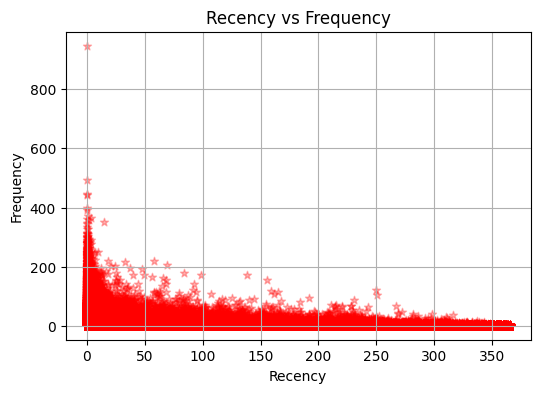

In [18]:
plt.figure(figsize=(6, 4))
plt.scatter(rfm['Recency'], rfm['Frequency'], color='red', marker='*', alpha=0.3)
plt.title('Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


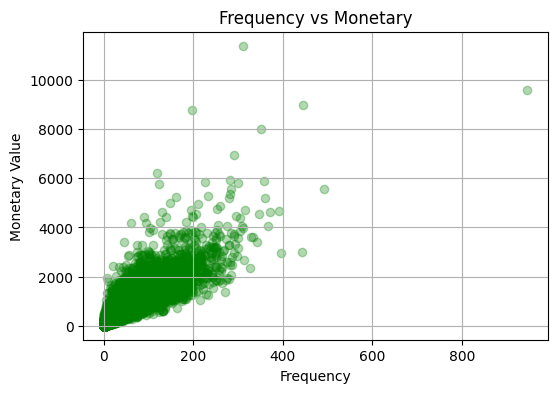

In [19]:
plt.figure(figsize=(6, 4))
plt.scatter(rfm['Frequency'], rfm['Monetary'], color='green', marker='o', alpha=0.3)
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.grid(True)
plt.show()


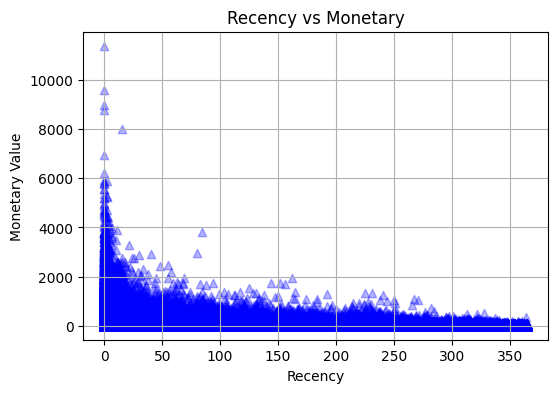

In [20]:
plt.figure(figsize=(6, 4))
plt.scatter(rfm['Recency'], rfm['Monetary'], color='blue', marker='^', alpha=0.3)
plt.title('Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary Value')
plt.grid(True)
plt.show()


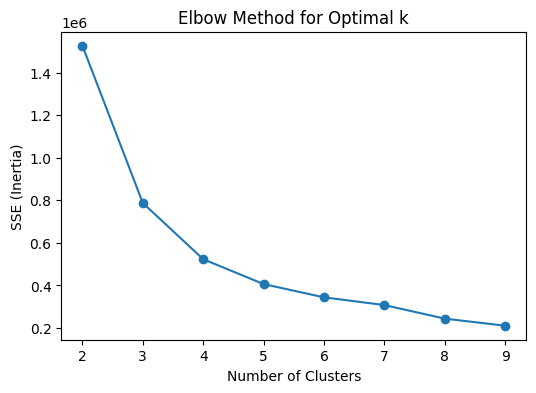

In [21]:
# This is where we need to use the rfm value to find the optimal number of clusters
# this will be the justification answer for the Question How you found the optimal state (is used elbow)
# also can use vector to find it like SVM (same thing but knn is more neighbour than outliers)
#The Elbow Method involves plotting the Within-Cluster Sum of Squares (WCSS) for different values of k (number of clusters). 
#As k increases, the WCSS decreases. However, after a certain point, the rate of decrease sharply slows down 
#— this "elbow point" is considered the optimal k.

sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()


In [22]:
# Now we already get the k value(optimum) now baru feed it to the model to find

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


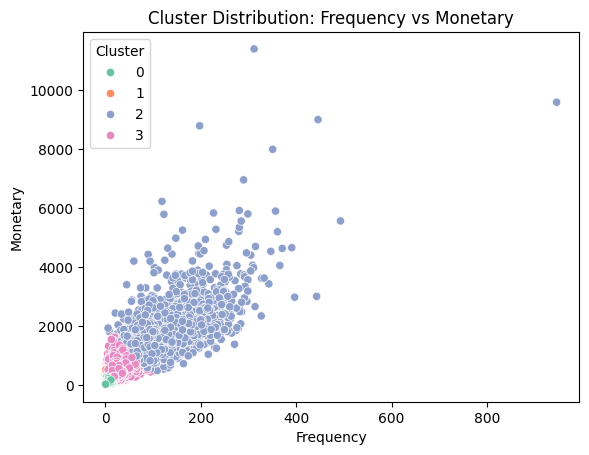

In [23]:
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2')
plt.title("Cluster Distribution: Frequency vs Monetary")
plt.show()


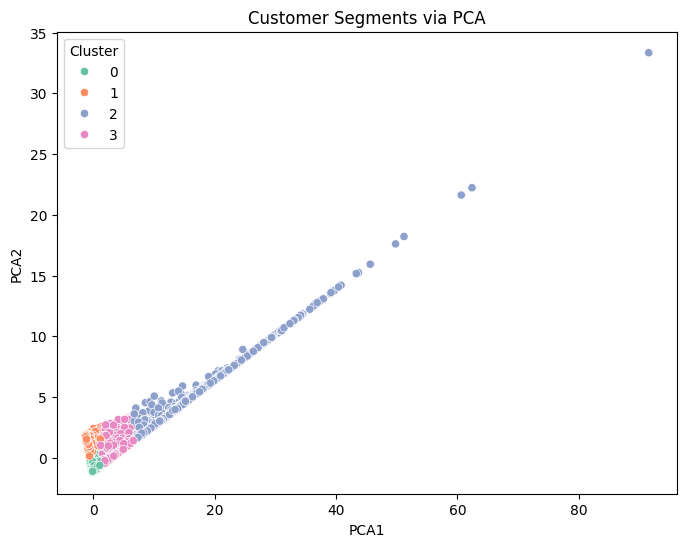

In [24]:
# We use PCA to segment the customer to see what these guiy are like based on the number of clusters (basically 4 types of cutsomer)

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Customer Segments via PCA")
plt.show()


In [25]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'customer_id': 'count'
}).round(2)

cluster_summary


Recency        Frequency        Monetary          customer_id
           mean median      mean median     mean   median       count
Cluster                                                              
0         52.61   41.0      3.90    2.0    61.35    39.60      425218
1        253.84  255.0      1.79    1.0    29.95    19.32      251952
2          6.90    2.0    102.33   89.0  1430.69  1252.19        4849
3         20.64   10.0     27.30   24.0   418.70   367.62       48466

In [26]:
# Size of each cluster
print("Cluster Sizes:")
print(rfm['Cluster'].value_counts())


Cluster Sizes:
Cluster
0    425218
1    251952
3     48466
2      4849
Name: count, dtype: int64


In [27]:
# Label accodring to teh data we have this is liek logical reasoning plus the pca using teh rfm 4

cluster_labels = {
    0: "Loyal High Spenders",
    1: "New Customers",
    2: "Churned",
    3: "Occasional Buyers"
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)
rfm[['customer_id', 'Recency', 'Frequency', 'Monetary', 'Segment']].head()


,customer_id,Recency,Frequency,Monetary,Segment
0,1000015,17,4,158.11,Loyal High Spenders
1,100002,45,20,334.03,Occasional Buyers
2,1000020,67,6,52.10,Loyal High Spenders
3,1000029,3,55,838.79,Occasional Buyers
4,1000035,15,8,125.11,Loyal High Spenders


In [28]:
rfm[['customer_id', 'Recency', 'Frequency', 'Monetary', 'Segment']].tail()

,customer_id,Recency,Frequency,Monetary,Segment
730480,99997,19,10,101.90,Loyal High Spenders
730481,999971,20,19,288.60,Occasional Buyers
730482,999972,318,1,27.71,New Customers
730483,99998,14,12,171.25,Loyal High Spenders
730484,999994,9,1,27.80,Loyal High Spenders


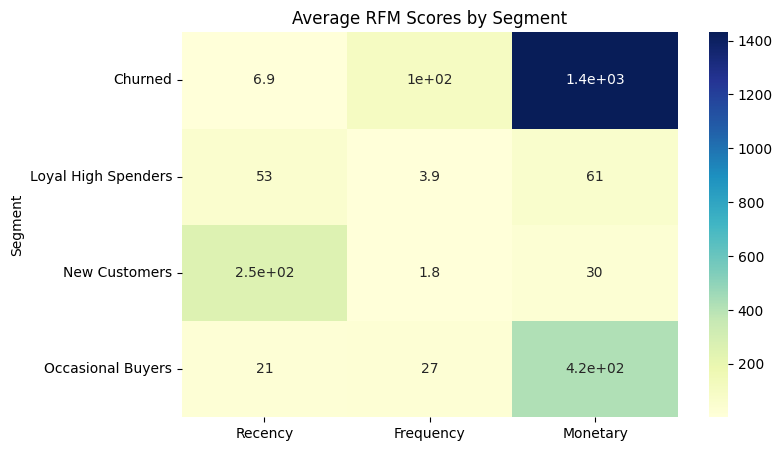

In [29]:
# Heatmap of Cluster Profiles
cluster_heatmap = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

plt.figure(figsize=(8,5))
sns.heatmap(cluster_heatmap, annot=True, cmap='YlGnBu')
plt.title("Average RFM Scores by Segment")
plt.show()


In [30]:
segment_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum', 'count']
}).round(2)

segment_summary.columns = ['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean', 'Monetary_Sum', 'Customer_Count']
segment_summary = segment_summary.reset_index()
segment_summary


,Segment,Recency_Mean,Frequency_Mean,Monetary_Mean,Monetary_Sum,Customer_Count
0,Churned,6.90,102.33,1430.69,6937426.87,4849
1,Loyal High Spenders,52.61,3.90,61.35,26085691.34,425218
2,New Customers,253.84,1.79,29.95,7545395.97,251952
3,Occasional Buyers,20.64,27.30,418.70,20292503.31,48466


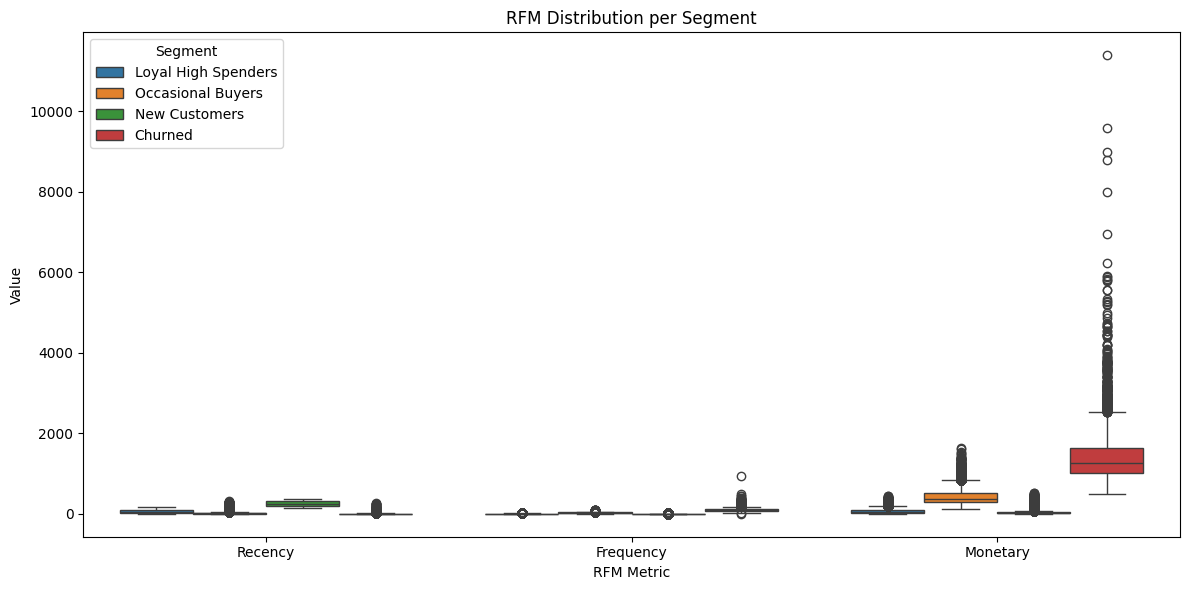

In [31]:
melted_rfm = pd.melt(rfm, id_vars='Segment', value_vars=['Recency', 'Frequency', 'Monetary'])

plt.figure(figsize=(12,6))
sns.boxplot(data=melted_rfm, x='variable', y='value', hue='Segment')
plt.title("RFM Distribution per Segment")
plt.xlabel("RFM Metric")
plt.ylabel("Value")
plt.legend(title='Segment')
plt.tight_layout()
plt.show()


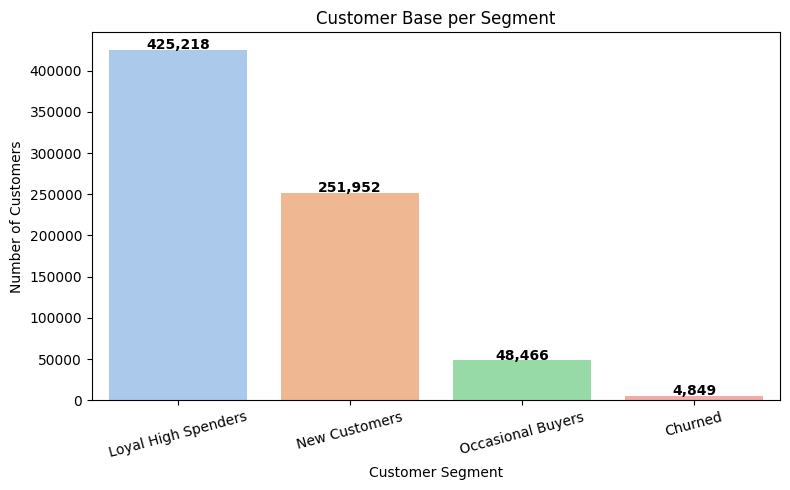

In [32]:

# Count customers per segment
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Customer_Count']

#Segment sort
segment_counts = segment_counts.sort_values(by='Customer_Count', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(data=segment_counts, x='Segment', y='Customer_Count', palette='pastel')
plt.title("Customer Base per Segment")
plt.ylabel("Number of Customers")
plt.xlabel("Customer Segment")
plt.xticks(rotation=15)

# Add value labels on top of bars
for index, row in segment_counts.iterrows():
    barplot.text(index, row.Customer_Count + 1000, f"{row.Customer_Count:,}", 
                 color='black', ha="center", fontweight='bold')

plt.tight_layout()
plt.show()


In [33]:
# Business Strategies per Segment
segment_strategies = {
    "Loyal High Spenders": "Reward with exclusive offers, loyalty programs.",
    "New Customers": "Send welcome emails, offer discounts to retain them.",
    "Churned": "Run re-engagement campaigns or surveys.",
    "Occasional Buyers": "Send personalized product recs or seasonal promos."
}

print("\nSegment Strategies:\n")
for seg, strat in segment_strategies.items():
    print(f"{seg}: {strat}")


Segment Strategies:

Loyal High Spenders: Reward with exclusive offers, loyalty programs.
New Customers: Send welcome emails, offer discounts to retain them.
Churned: Run re-engagement campaigns or surveys.
Occasional Buyers: Send personalized product recs or seasonal promos.


## Final Analysis and Interpretation

Following the RFM analysis and KMeans clustering, I have successfully segmented the customers into distinct groups based on their purchasing behavior. Each segment reflects specific characteristics regarding how recently, how often, and how much customers spend. This segmentation enables a more targeted and strategic approach to customer engagement.

### Identified Customer Segments and Strategic Recommendations:

**1. Loyal High Spenders**  
These customers buy frequently and spend significantly.  
**Strategy:** Focus on retention through exclusive benefits, early access to new products, and loyalty rewards. This group represents strong long-term value.

**2. New Customers**  
Recently acquired customers with limited purchase history.  
**Strategy:** Introduce them to your brand through personalized onboarding, welcome offers, and educational content about products or services.

**3. Churned or At-Risk Customers**  
Customers who have not made recent purchases and show declining engagement.  
**Strategy:** Implement re-engagement campaigns with personalized offers or feedback surveys to understand their drop-off and potentially win them back.

**4. Occasional Buyers**  
These customers purchase infrequently with average spending.  
**Strategy:** Maintain engagement through targeted promotions, seasonal offers, and product recommendations based on previous behavior.

---

This clustering approach allows for more informed decision-making by aligning marketing and retention strategies with actual customer behavior patterns. Tailoring communication and offers to each segment can lead to improved customer satisfaction, increased retention, and stronger business outcomes.
